# Transfer Learning - Part 3
## Scaling Up

The previous two notebooks that I am digging into Transfer Learning has been done using only 10 food vision classes, but there are 101 classes in the actual dataset. The purpose of this notebook is to scale up and look at a larger model.

The goal is to beat the original Food 101 paper with only 10% of the training data. The paper accuracy was 50.76% when training on 101,000 images.

For this part, I am going to look at only 10% of the entire 101 image classes. 

* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

## Imports

In [1]:
import datetime
import logging
import os
import pathlib
import random
import sys
import typing

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import ml_toolbox
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [2]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-20 17:57:25.000682


In [3]:
tf.__version__

'2.13.0'

In [4]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [6]:
RANDOM_SEED = 42
IMAGE_SIZE = 224

## Helpers

In [7]:
def get_label_image_filepaths(directory: str) -> typing.List[typing.Tuple[str, str]]:
    """ Gets a list of image filepaths from a directory.

        Args:
            directory (str): the directory to search for all images within.

        Returns:
            (List[str]) the list of image filepaths.
    """
    image_dirs = [(dir, files) for dir, _, files in os.walk(directory) if files and files[0].endswith('jpeg')]
    
    label_filepaths = []
    for dir, files in image_dirs:
        label = dir.split('/')[-1]
        label_filepaths.extend([(label, f'{dir}/{file}') for file in files])

    return label_filepaths

## Downloading, Analyzing, & Creating Datasets

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at 101 image classes, but only 10% of the training data to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

### Download & Analyze Data

In [8]:
data_directory = pathlib.Path('./data/food-101/101_food_classes_10_percent/')
train_directory = data_directory / 'train'
test_directory = data_directory / 'test'

In [9]:
ml_toolbox.analysis.image.summarize_directory(data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/foie_gras Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/club_sandwich Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/cheese_plate Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/cup_cakes Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/garlic_bread Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/gnocchi Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/101_food_classes_10_percent/test/ice_cream Total Images: 250
INFO:py_learning_toolbox.ml_toolb

#### Findings

After looking at the directory, looks like there are 75 training images for each category of food, and 250 test images for each category of food.

### Creating Datasets

In [10]:
# Constants
BATCH_SIZE = 32

In [11]:
train_data = tf.keras.utils.image_dataset_from_directory(str(train_directory),
                                                         image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                         batch_size=BATCH_SIZE,
                                                         label_mode='categorical')

test_data = tf.keras.utils.image_dataset_from_directory(str(test_directory),
                                                        image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                        shuffle=False,
                                                        batch_size=BATCH_SIZE,
                                                        label_mode='categorical')

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [12]:
num_image_classes = len(train_data.class_names)
num_image_classes

101

In [13]:
_, test_labels = data_toolbox.split_data_labels_from_dataset(test_data)
test_labels = tf.argmax(test_labels, axis=1)
test_labels

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([  0,   0,   0, ..., 100, 100, 100])>

## Experiments

* Experiment-0: Baseline Model to begin training Output Features
* Experiment-1: Fine Tuned Model from Experiment-0
* Experiment-2: External Model w/ same Architecture & Hyperparameters as Experiment-1

#### NOTE: Creating a Model

Steps to creating the model to identify 101 food classes.

1. Create a model checkpoint callback. (**UPDATE** I ended up adding two additional callbacks to better save checkpoints of the trained model)
2. Create a data augmentation layer to build the data augmentation into the model directly.
3. Build a headless (no top layers) functional EfficientNetB0 base model.
4. Compile our Model.
5. Feature extract for 5 epochs on training data set, and validate on 15% of the test data to save time per epoch.
6. Adjust model and repeate (implement fine tuning, etc...)

### Experiment Constants

In [14]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

TRAIN_STEPS_PER_EPOCH = len(train_data)
VAL_STEPS_PER_EPOCH = int(0.15 * len(test_data))

EPOCHS = 5

### Common Layers

A handful of layers are common across all experiments that I want to define for reuse.

#### Augmentation Layer

Augmenting data as a layer in the data model. Preprocessing and augmenting data can be done as a layer in the model.

Benefits:
* Data augmentation is done on the GPU instead of the CPU
* Image data augmentation is only done on the training data, so we can still export our model and use it elsewhere.

In [15]:
# Data Augmentation Layer (Scaling layer not required because EfficientNetB0 already has that incorporated)
data_augmentation = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
])

### Experiment-0: Training on 10% Data w/out Fine Tuning

The first experiment will use the EfficientNet architecture with augmented data, however, it will not incorporate fine tuning. 

In [16]:
# Constants
model_0_name = 'model_0_effnet_aug_untrainable'

In [17]:
# Building out the Transfer Learning Model
# EfficientNetB0 Base Model
base_model_0 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_0.trainable = False

# Build Layers
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name='InputLayer')

x = data_augmentation(inputs)
x = base_model_0(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

outputs = tf.keras.layers.Dense(num_image_classes, activation='softmax', name='OutputLayer')(x)

# Build the model
model_0 = tf.keras.models.Model(inputs, outputs, name=model_0_name)
model_0.summary()

Model: "model_0_effnet_aug_untrainable"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 OutputLayer (Dense)         (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Tra

In [18]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_0_history = model_0.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[])

Epoch 1/5
237/237 [==============================] - 106s 437ms/step - loss: 3.3725 - accuracy: 0.2742 - val_loss: 2.4101 - val_accuracy: 0.4876
Epoch 2/5
237/237 [==============================] - 104s 440ms/step - loss: 2.1741 - accuracy: 0.5039 - val_loss: 1.9802 - val_accuracy: 0.5323
Epoch 3/5
237/237 [==============================] - 104s 439ms/step - loss: 1.8047 - accuracy: 0.5736 - val_loss: 1.8201 - val_accuracy: 0.5487
Epoch 4/5
237/237 [==============================] - 104s 437ms/step - loss: 1.5984 - accuracy: 0.6088 - val_loss: 1.7674 - val_accuracy: 0.5466
Epoch 5/5
237/237 [==============================] - 103s 437ms/step - loss: 1.4505 - accuracy: 0.6416 - val_loss: 1.7118 - val_accuracy: 0.5572


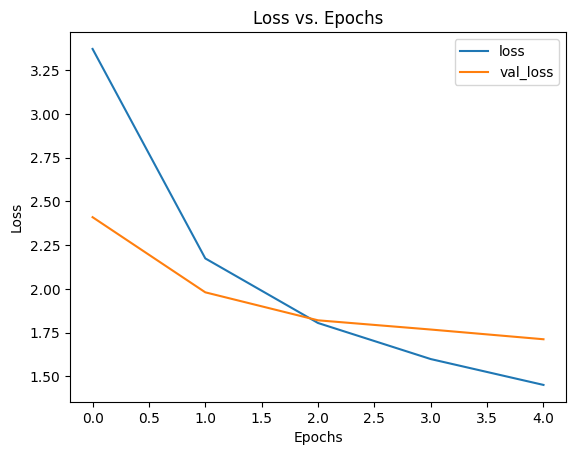

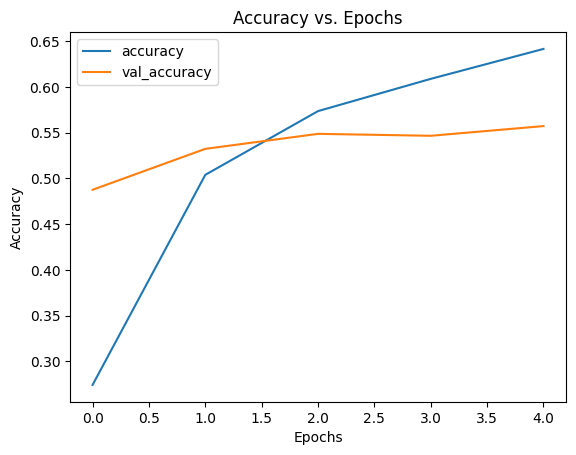

In [19]:
ml_toolbox.analysis.history.plot_history(model_0_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_0_history, metric='accuracy')

In [20]:
model_0_pred_probs = model_0.predict(test_data)
model_0_preds = tf.argmax(model_0_pred_probs, axis=1)

model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_0_preds, name=model_0_name)
model_0_results

790/790 [==============================] - 233s 294ms/step


ClassificationPredictionMetrics(accuracy=0.5865742574257425, precision=0.6121039216401299, recall=0.5865742574257425, f1=0.5845347592857746, name='model_0_effnet_aug_untrainable')

#### Findings

After looking at the accuracy and loss curves above, looks to be that the training data is overfitting. Going to attempt to reduce overfitting in the next models.

### Experiment-1: Fine Tuned Model

To potentially reduce overfitting, I am going  to unfreeze the last 5 layers in the base model and retrain the model.

In [21]:
# Constants
model_1_name = 'model_1_effnet_tuned'

INITIAL_EPOCH = 5

In [22]:
# Starting from model_0 (Reloading in where model_0 left off from)
base_model_0.trainable = True

# Setting all but last 5 layers in base_model to be not traininable (only last 5 layers are trainable)
for layer in base_model_0.layers[:-5]:
    layer.trainable = False

# How many trainable variables are in base model
print('Total Trainable Variables: ', len(model_0.layers[2].trainable_variables))

Total Trainable Variables:  6


In [23]:
# Compile Model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

# Fit Model
model_1_history = model_0.fit(train_data,
                              epochs=INITIAL_EPOCH + EPOCHS,
                              initial_epoch=INITIAL_EPOCH,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=test_data,
                              validation_steps=VAL_STEPS_PER_EPOCH,
                              callbacks=[])

Epoch 6/10
237/237 [==============================] - 110s 458ms/step - loss: 1.2062 - accuracy: 0.6866 - val_loss: 1.6795 - val_accuracy: 0.5564
Epoch 7/10
237/237 [==============================] - 107s 451ms/step - loss: 1.0749 - accuracy: 0.7160 - val_loss: 1.6946 - val_accuracy: 0.5556
Epoch 8/10
237/237 [==============================] - 106s 449ms/step - loss: 1.0259 - accuracy: 0.7241 - val_loss: 1.6963 - val_accuracy: 0.5599
Epoch 9/10
237/237 [==============================] - 107s 452ms/step - loss: 0.9439 - accuracy: 0.7464 - val_loss: 1.7487 - val_accuracy: 0.5442
Epoch 10/10
237/237 [==============================] - 107s 452ms/step - loss: 0.8810 - accuracy: 0.7636 - val_loss: 1.6731 - val_accuracy: 0.5641


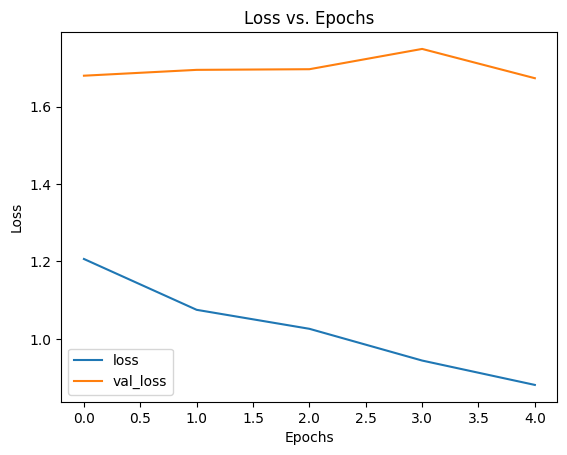

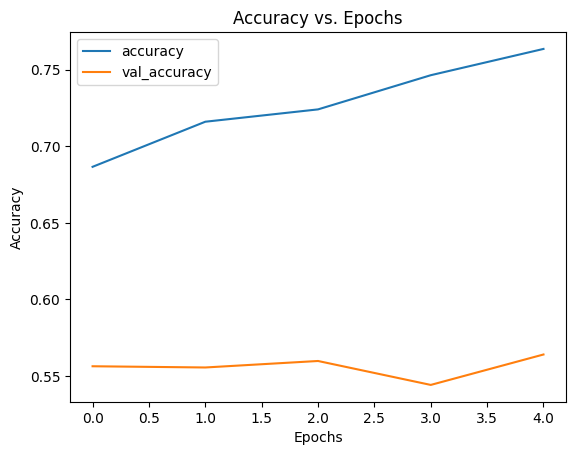

In [24]:
ml_toolbox.analysis.history.plot_history(model_1_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_1_history, metric='accuracy')

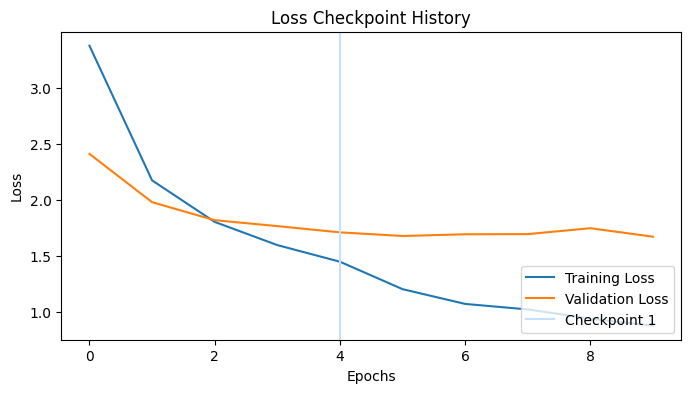

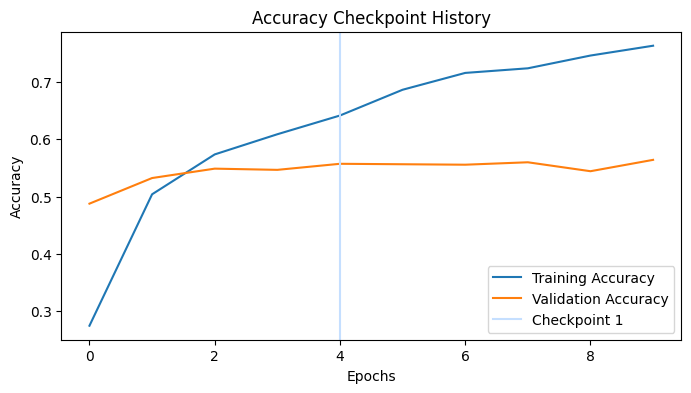

In [25]:
ml_toolbox.analysis.history.plot_sequential_histories([model_0_history, model_1_history], metric='loss', figsize=(8,4))
ml_toolbox.analysis.history.plot_sequential_histories([model_0_history, model_1_history], metric='accuracy', figsize=(8,4))

In [26]:
model_1_pred_probs = model_0.predict(test_data)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_1_preds, name=model_1_name)
model_1_results

790/790 [==============================] - 226s 286ms/step


ClassificationPredictionMetrics(accuracy=0.6045148514851485, precision=0.6370500771343832, recall=0.6045148514851485, f1=0.6072261361640608, name='model_1_effnet_tuned')

### Experiment-2: Evaluating Fine Tuned Model

There is already a model created using this dataset from the Udemy course this notebook follows. For this experiment, I am going to load that model and use it directly.

The purpose of this experiment is to make some predictions, visualize them, then find out which predictions were the most wrong. To do this, as mentioned, I am going to use the already fine tuned and exported model associated with the course this notebook follows at the link below:

* https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [27]:
# Constants
model_2_name = 'model_2_pretrained_model'

external_model_path = './models/06_101_food_class_10_percent_saved_big_dog_model'

In [28]:
model_2 = tf.keras.models.load_model(external_model_path)
model_2._name = model_2_name

INFO:absl:Fingerprint not found. Saved model loading will continue.


In [29]:
# Making predictions with the model
model_2_pred_probs = model_2.predict(test_data)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_2_preds, name=model_2_name)
model_2_results

790/790 [==============================] - 223s 282ms/step


ClassificationPredictionMetrics(accuracy=0.6077623762376237, precision=0.6328666845830311, recall=0.6077623762376237, f1=0.606125219724578, name='model_2_pretrained_model')

#### Confusion Matrix

In [30]:
ml_toolbox.analysis.classification.plot_confusion_matrix(test_labels, model_2_preds, classes=test_data.class_names, figsize=(120,120))

#### Findings

After looking at the confusion matrix, the model performed decently well, however, foods that appear to look similar confuse the model. For instance, tira misue and chocolate cake are commonly mixed up, as well as springs rolls and samosas.

#### Classification Report

Scitkit learn has a helpful function to get many classification metrics per class.

In [31]:
print(classification_report(test_labels, model_2_preds))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

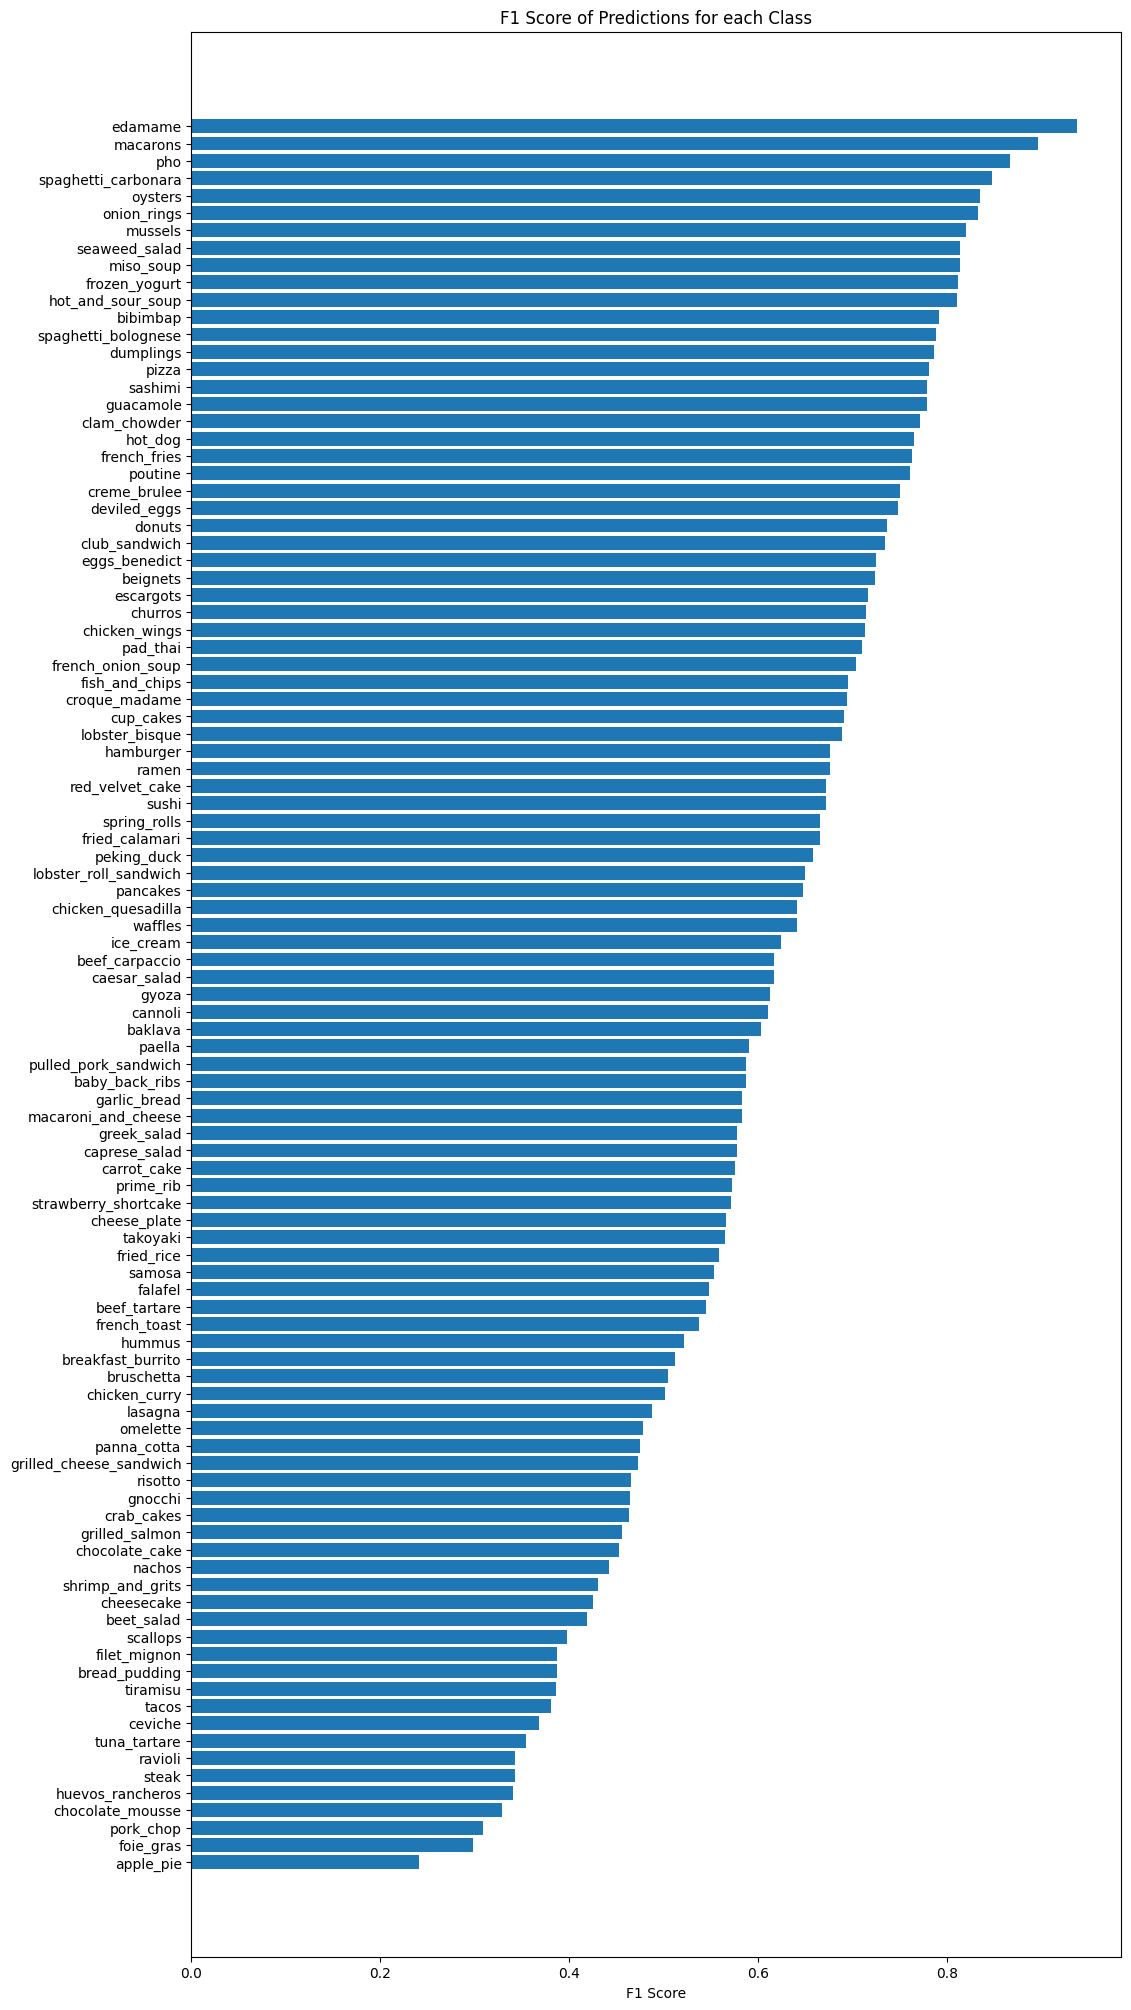

In [32]:
ml_toolbox.analysis.classification.plot_classification_report(test_labels, model_2_preds, test_data.class_names)

## Analysis

After running the three experiments, I want to analyze them to see the differences between them.

In [33]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
]
all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

accuracy  precision    recall        f1
model_0_effnet_aug_untrainable  0.586574   0.612104  0.586574  0.584535
model_1_effnet_tuned            0.604515   0.637050  0.604515  0.607226
model_2_pretrained_model        0.607762   0.632867  0.607762  0.606125

<Axes: >

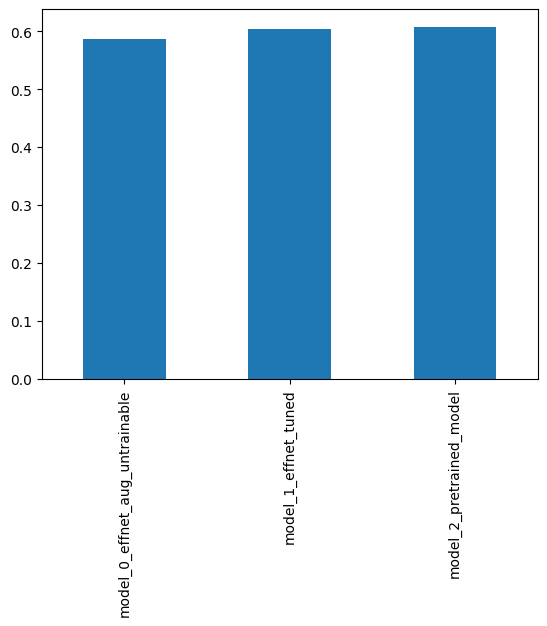

In [34]:
all_results_df['accuracy'].sort_values().plot(kind='bar')

#### Findings

From comparing the three experiments, Experiment-1 and Experiment-2 (External Model) performed roughly equivalently. This makes sense due to the architecture and hyperparameters for those experiments being identical, with the only difference being that one was an external model.

## Testing Model

To visualize our model's prediction on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

### Testing Model on Test Images

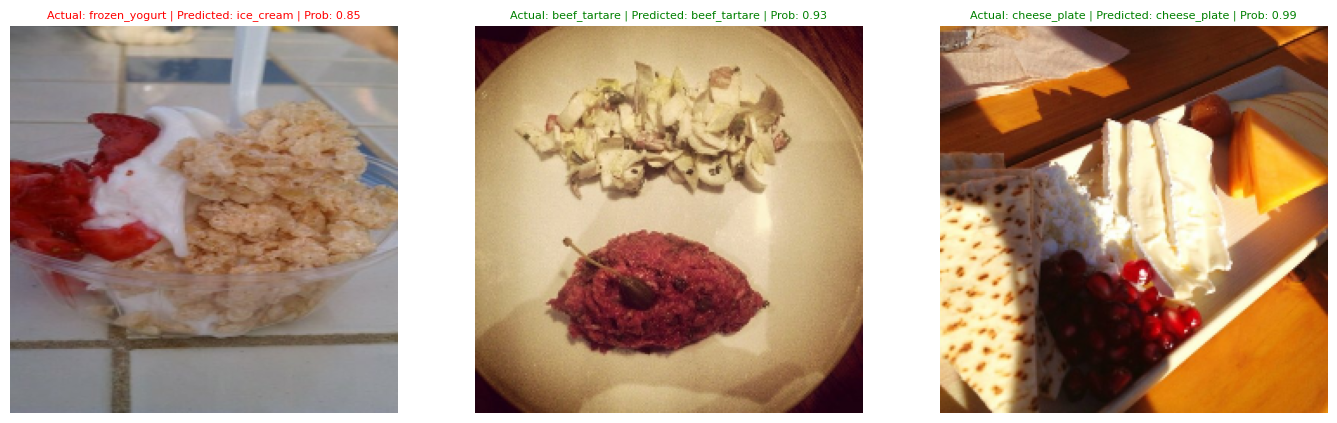

In [44]:
# Displaying random image from test dataset, the predicted model, and our model's prediction
plt.figure(figsize=(17,10))

for i in range(3):
    # Choose a random test image from a random class directory
    random_class_name = random.choice(test_data.class_names)
    test_class_dir = f'{str(test_directory)}/{random_class_name}'
    filename = random.choice(os.listdir(f'{str(test_directory)}/{random_class_name}'))
    file_path = f'{test_class_dir}/{filename}'

    # Predict image
    img = ml_toolbox.preprocessing.image.load_and_resize_image(file_path, scale=False)
    expanded_img = tf.expand_dims(img, axis=0)
    pred_prob = model_2.predict(expanded_img, verbose=0)
    pred_class = test_data.class_names[pred_prob.argmax()]

    # Plot images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if random_class_name == pred_class:
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f'Actual: {random_class_name} | Predicted: {pred_class} | Prob: {pred_prob.max():.2f}', color=title_color, size=8)
    plt.axis(False)

### Identifying Most Incorrect Predictions

To get a better insight on what is confusing the model, we are going to look at predictions that had the highest confidence in their prediction, but they ended up being wrong. This can reveal some of the following insights:

* Data issues (wrong labels, e.g. model is correct but the true label is wrong)
* Confusing classes (get better/more diverse data)

To find out where the model is guessing wrong, going to find the following:

1. Get all the image file paths in the test dataset
2. Create a Pandas DF of the image file path, the true label, predicted class, and max predicted probabilities
3. Use DF to find all the incorrect predictions
4. Sort DF based on incorrect predictions with the highest probability predictions at the top
5. Visualize the images with the most wrong predictions

In [37]:
test_data_file_paths = ml_toolbox.analysis.image.get_filepaths_from_dataset(test_data, str(test_directory))

len(test_data_file_paths), test_data_file_paths[0]

(25250,
 b'data/food-101/101_food_classes_10_percent/test/apple_pie/1011328.jpg')

In [38]:
top_50_incorrect_predicted_df = ml_toolbox.analysis.image.get_top_n_mislabeled_images(test_labels,
                                                                                      model_2_pred_probs,
                                                                                      test_data_file_paths,
                                                                                      test_data.class_names,
                                                                                      50)
top_50_incorrect_predicted_df

filepath  y_true  y_pred  \
21810  b'data/food-101/101_food_classes_10_percent/te...      87      29   
231    b'data/food-101/101_food_classes_10_percent/te...       0     100   
15359  b'data/food-101/101_food_classes_10_percent/te...      61      53   
23539  b'data/food-101/101_food_classes_10_percent/te...      94      83   
21400  b'data/food-101/101_food_classes_10_percent/te...      85      92   
24540  b'data/food-101/101_food_classes_10_percent/te...      98      83   
2511   b'data/food-101/101_food_classes_10_percent/te...      10      61   
5574   b'data/food-101/101_food_classes_10_percent/te...      22      21   
17855  b'data/food-101/101_food_classes_10_percent/te...      71      65   
23797  b'data/food-101/101_food_classes_10_percent/te...      95      86   
18001  b'data/food-101/101_food_classes_10_percent/te...      72      67   
11642  b'data/food-101/101_food_classes_10_percent/te...      46      10   
10847  b'data/food-101/101_food_classes_10_percent/te...      43      68   
23631  b'data/food-101/101_food_classes_10_percent/te...      94      83   
1155   b'data/food-101/101_food_classes_10_percent/te...       4       5   
10854  b'data/food-101/101_food_classes_10_percent/te...      43      68   
23904  b'data/food-101/101_food_classes_10_percent/te...      95      86   
7316   b'data/food-101/101_food_classes_10_percent/te...      29      83   
13144  b'data/food-101/101_food_classes_10_percent/te...      52      92   
10880  b'data/food-101/101_food_classes_10_percent/te...      43      68   
10741  b'data/food-101/101_food_classes_10_percent/te...      42       1   
5338   b'data/food-101/101_food_classes_10_percent/te...      21      16   
24621  b'data/food-101/101_food_classes_10_percent/te...      98      22   
9416   b'data/food-101/101_food_classes_10_percent/te...      37      21   
920    b'data/food-101/101_food_classes_10_percent/te...       3      81   
11196  b'data/food-101/101_food_classes_10_percent/te...      44      67   
22     b'data/food-101/101_food_classes_10_percent/te...       0     100   
8076   b'data/food-101/101_food_classes_10_percent/te...      32      57   
17897  b'data/food-101/101_food_classes_10_percent/te...      71      65   
24913  b'data/food-101/101_food_classes_10_percent/te...      99      85   
14599  b'data/food-101/101_food_classes_10_percent/te...      58      45   
9583   b'data/food-101/101_food_classes_10_percent/te...      38      40   
15142  b'data/food-101/101_food_classes_10_percent/te...      60      64   
7521   b'data/food-101/101_food_classes_10_percent/te...      30      61   
8794   b'data/food-101/101_food_classes_10_percent/te...      35      41   
14631  b'data/food-101/101_food_classes_10_percent/te...      58      45   
5306   b'data/food-101/101_food_classes_10_percent/te...      21      83   
9326   b'data/food-101/101_food_classes_10_percent/te...      37      79   
2776   b'data/food-101/101_food_classes_10_percent/te...      11      51   
14482  b'data/food-101/101_food_classes_10_percent/te...      57      51   
14691  b'data/food-101/101_food_classes_10_percent/te...      58      79   
21856  b'data/food-101/101_food_classes_10_percent/te...      87      36   
15826  b'data/food-101/101_food_classes_10_percent/te...      63      29   
19521  b'data/food-101/101_food_classes_10_percent/te...      78      40   
4737   b'data/food-101/101_food_classes_10_percent/te...      18      60   
24007  b'data/food-101/101_food_classes_10_percent/te...      96      19   
19419  b'data/food-101/101_food_classes_10_percent/te...      77      37   
17107  b'data/food-101/101_food_classes_10_percent/te...      68      52   
8245   b'data/food-101/101_food_classes_10_percent/te...      32      52   
1159   b'data/food-101/101_food_classes_10_percent/te...       4      79   

       y_pred_prob       y_true_classname       y_pred_classname  
21810     0.999997               scallops              cup_cakes  
231       0.999995              apple

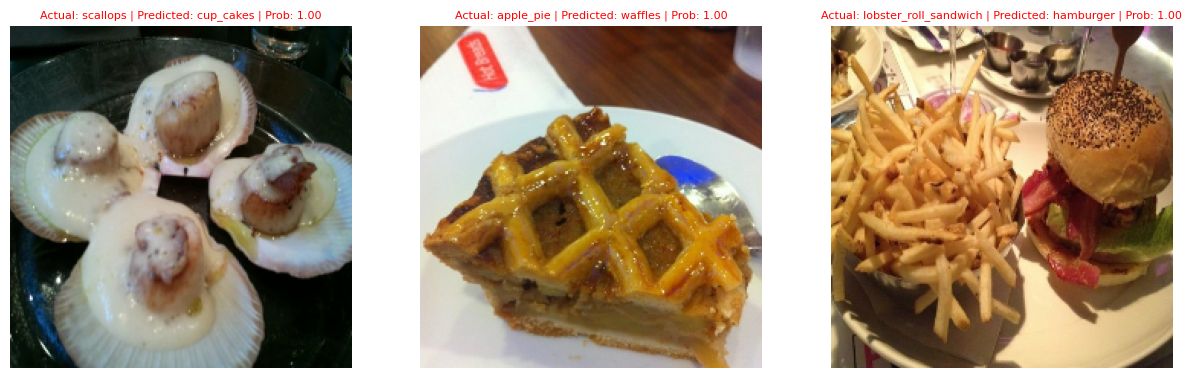

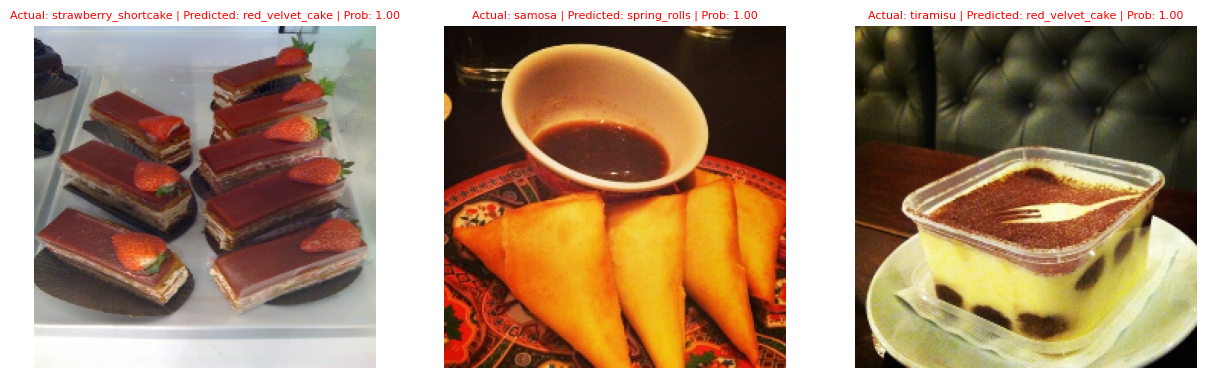

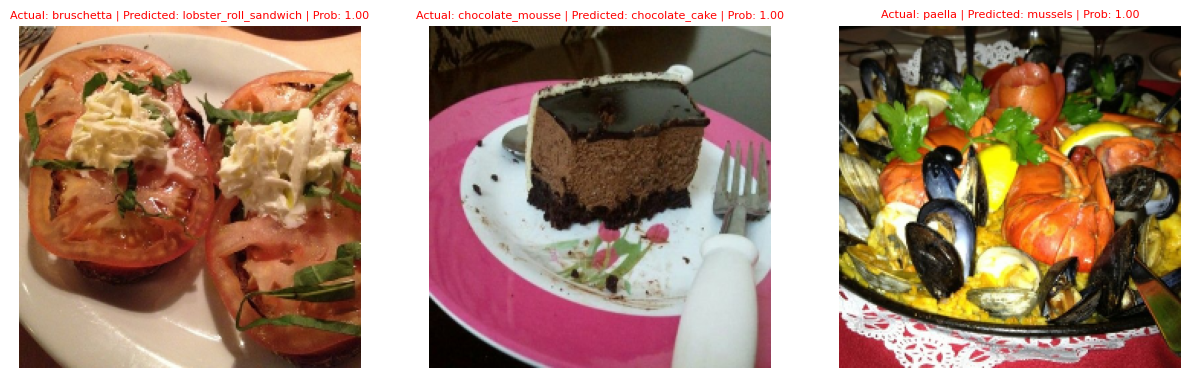

In [39]:
# Displaying first 9 images from test dataset, the predicted model, and our model's prediction
start_index = 0
images_to_view = 9
for i, row in enumerate(top_50_incorrect_predicted_df[start_index:start_index + images_to_view].iterrows()):
    if i % 3 == 0:
        plt.figure(figsize=(15,10))

    # Predict image
    img = ml_toolbox.preprocessing.image.load_and_resize_image(row[1].filepath, scale=False)
    expanded_img = tf.expand_dims(img, axis=0)

    # Plot images    
    plt.subplot(1, 3, i % 3 + 1)
    plt.imshow(img/255.)
    if row[1].y_true_classname == row[1].y_pred_classname:
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f'Actual: {row[1].y_true_classname} | Predicted: {row[1].y_pred_classname} | Prob: {row[1].y_pred_prob:.2f}', color=title_color, size=8)
    plt.axis(False)

### Testing Model on Custom Images

Now that I have seen the model's worst predictions, I want to see how it performs on custom images.

In [40]:
# Constants
image_dir = './data/food-101/model_testing'

In [41]:
custom_image_label_dirs = get_label_image_filepaths(image_dir)
custom_image_label_dirs

[('steak', './data/food-101/model_testing/steak/steak.jpeg'),
 ('steak', './data/food-101/model_testing/steak/steak-and-eggs.jpeg'),
 ('sushi', './data/food-101/model_testing/sushi/sushi.jpeg'),
 ('chicken_wings',
  './data/food-101/model_testing/chicken_wings/chicken_wings.jpeg'),
 ('hamburger', './data/food-101/model_testing/hamburger/hamburger.jpeg'),
 ('pizza', './data/food-101/model_testing/pizza/pizza-dad.jpeg'),
 ('ramen', './data/food-101/model_testing/ramen/ramen.jpeg')]

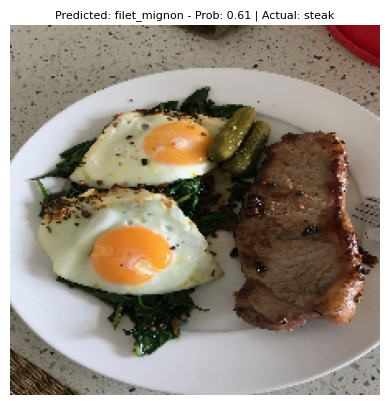

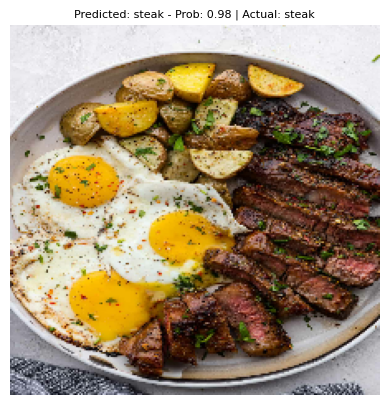

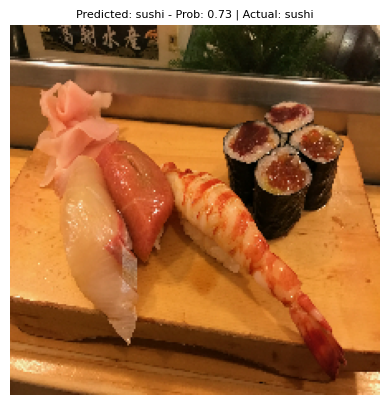

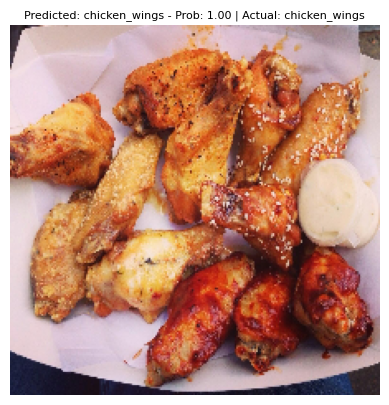

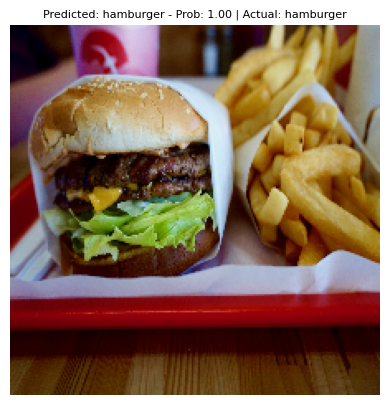

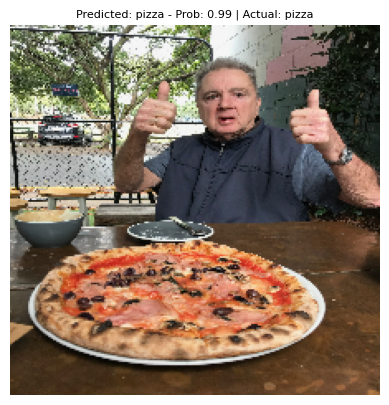

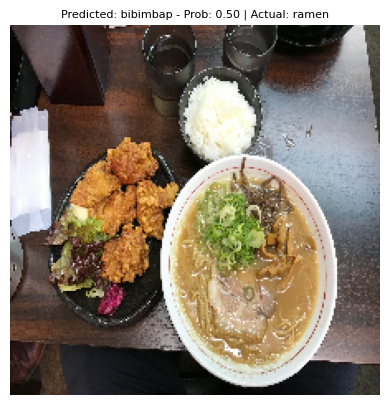

In [43]:
for image_label, image_filename in custom_image_label_dirs:
    # Predict image
    img = ml_toolbox.preprocessing.image.load_and_resize_image(image_filename, scale=False)
    expanded_img = tf.expand_dims(img, axis=0)
    pred_prob = model_2.predict(expanded_img, verbose=0)
    pred_class = test_data.class_names[pred_prob.argmax()]

    # Plot images
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f'Predicted: {pred_class} - Prob: {pred_prob.max():.2f} | Actual: {image_label}', size=8)
    plt.axis(False)